<a href="https://colab.research.google.com/github/SeunghyeChae/tmdhey/blob/main/GAN_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xray GAN

In [1]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100, 
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            
            # Output Layer
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.main(x)
        return x

In [3]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            
            # (batch_size, 1, 64, 64)
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=4,
                      stride=2,
                      padding=1, 
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 64, 32, 32)
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 128, 16, 16)
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 256, 8, 8)
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 512, 4, 4)
            nn.Conv2d(in_channels=512,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            
            # (batch_size, 1, 1, 1)
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        x = self.main(x)
        return x

In [4]:
G = Generator()
G(torch.randn(12, 100, 1, 1)).shape

torch.Size([12, 1, 64, 64])

In [5]:
D = Discriminator()
D(torch.randn(14, 1, 64, 64)).shape

torch.Size([14, 1, 1, 1])

In [6]:
def build_data_loader(batch_size):
    dataset = torchvision.datasets.ImageFolder(
        root='/content/drive/MyDrive/cakd_colab/2차플젝/데이터 원본/데이터 원본/image',
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(64), 
            torchvision.transforms.CenterCrop(64), 
            torchvision.transforms.Grayscale(), 
            torchvision.transforms.ToTensor(), 
        ]))
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

In [15]:
for data, _ in build_data_loader(8):
    test_images = data
    break
    
print(test_images.shape)
show_images(test_images)

In [9]:
compute_loss = nn.BCELoss()

In [10]:
n_epochs = 100
batch_size = 2

In [11]:
gpu = torch.device(0)
G = G.to(gpu)
D = D.to(gpu)

In [12]:
optimizer_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
data_loader = build_data_loader(batch_size)
test_noise = torch.randn((8, 100, 1, 1)).to(gpu)

Epoch: 0/100
Example images:


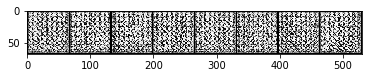

Epoch: 0	Batch: 147/148
Loss G: 7.8554205894470215
Loss D: 0.0010858714813366532
Epoch: 1/100
Example images:


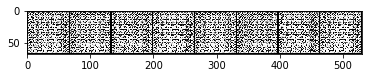

Epoch: 1	Batch: 147/148
Loss G: 10.650002479553223
Loss D: 0.00030968437204137444
Epoch: 2/100
Example images:


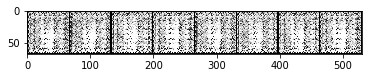

Epoch: 2	Batch: 147/148
Loss G: 18.127174377441406
Loss D: 0.3251955211162567
Epoch: 3/100
Example images:


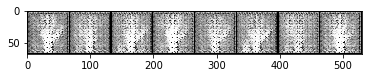

Epoch: 3	Batch: 147/148
Loss G: 4.367206573486328
Loss D: 0.08528333902359009
Epoch: 4/100
Example images:


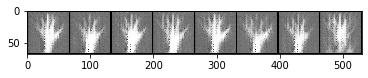

Epoch: 4	Batch: 147/148
Loss G: 10.388481140136719
Loss D: 0.9383681416511536
Epoch: 5/100
Example images:


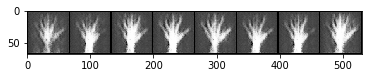

Epoch: 5	Batch: 147/148
Loss G: 6.3597002029418945
Loss D: 0.011071688495576382
Epoch: 6/100
Example images:


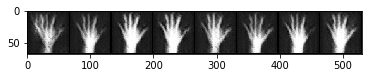

Epoch: 6	Batch: 147/148
Loss G: 2.128769874572754
Loss D: 0.13888122141361237
Epoch: 7/100
Example images:


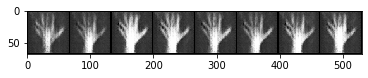

Epoch: 7	Batch: 147/148
Loss G: 5.93277645111084
Loss D: 0.24609075486660004
Epoch: 8/100
Example images:


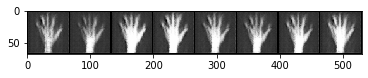

Epoch: 8	Batch: 147/148
Loss G: 4.443422794342041
Loss D: 0.03715971112251282
Epoch: 9/100
Example images:


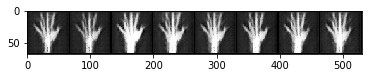

Epoch: 9	Batch: 147/148
Loss G: 4.294461727142334
Loss D: 0.04202113673090935
Epoch: 10/100
Example images:


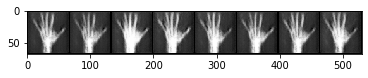

Epoch: 10	Batch: 147/148
Loss G: 5.467316627502441
Loss D: 0.013635851442813873
Epoch: 11/100
Example images:


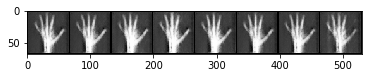

Epoch: 11	Batch: 147/148
Loss G: 4.4327616691589355
Loss D: 0.08322469145059586
Epoch: 12/100
Example images:


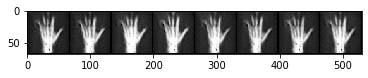

Epoch: 12	Batch: 147/148
Loss G: 10.378067970275879
Loss D: 0.0009769193129613996
Epoch: 13/100
Example images:


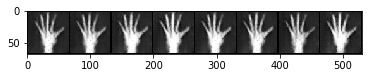

Epoch: 13	Batch: 147/148
Loss G: 3.9030776023864746
Loss D: 0.036326006054878235
Epoch: 14/100
Example images:


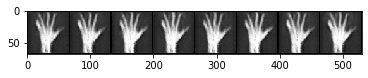

Epoch: 14	Batch: 147/148
Loss G: 8.247981071472168
Loss D: 0.018908502534031868
Epoch: 15/100
Example images:


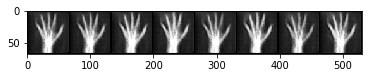

Epoch: 15	Batch: 147/148
Loss G: 5.560276508331299
Loss D: 0.009370040148496628
Epoch: 16/100
Example images:


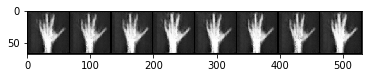

Epoch: 16	Batch: 147/148
Loss G: 4.072940826416016
Loss D: 0.07126666605472565
Epoch: 17/100
Example images:


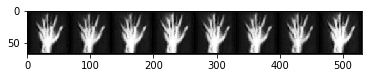

Epoch: 17	Batch: 147/148
Loss G: 5.706572532653809
Loss D: 0.004066892899572849
Epoch: 18/100
Example images:


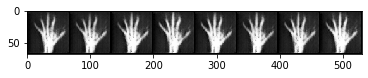

Epoch: 18	Batch: 147/148
Loss G: 4.45698356628418
Loss D: 0.0421612523496151
Epoch: 19/100
Example images:


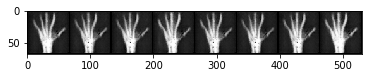

Epoch: 19	Batch: 147/148
Loss G: 5.219761848449707
Loss D: 0.05131039768457413
Epoch: 20/100
Example images:


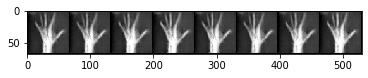

Epoch: 20	Batch: 147/148
Loss G: 5.539867401123047
Loss D: 0.007679712027311325
Epoch: 21/100
Example images:


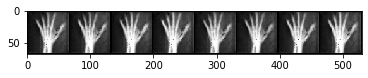

Epoch: 21	Batch: 147/148
Loss G: 6.40820837020874
Loss D: 0.00110662414226681
Epoch: 22/100
Example images:


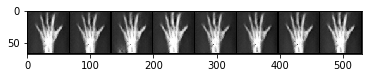

Epoch: 22	Batch: 147/148
Loss G: 4.585361957550049
Loss D: 0.06175551936030388
Epoch: 23/100
Example images:


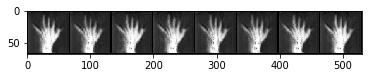

Epoch: 23	Batch: 147/148
Loss G: 5.367285251617432
Loss D: 0.016348285600543022
Epoch: 24/100
Example images:


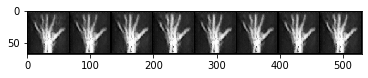

Epoch: 24	Batch: 147/148
Loss G: 4.11907434463501
Loss D: 0.06482720375061035
Epoch: 25/100
Example images:


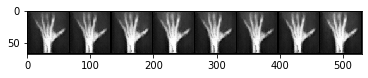

Epoch: 25	Batch: 147/148
Loss G: 7.058791637420654
Loss D: 0.007449250668287277
Epoch: 26/100
Example images:


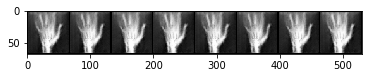

Epoch: 26	Batch: 147/148
Loss G: 5.883364677429199
Loss D: 0.004581132438033819
Epoch: 27/100
Example images:


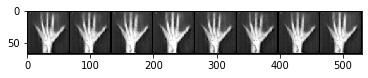

Epoch: 27	Batch: 147/148
Loss G: 3.895859956741333
Loss D: 0.0184161439538002
Epoch: 28/100
Example images:


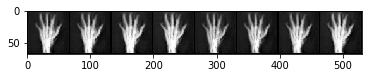

Epoch: 28	Batch: 147/148
Loss G: 4.043606758117676
Loss D: 0.05942719802260399
Epoch: 29/100
Example images:


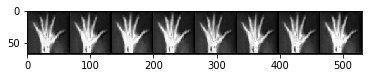

Epoch: 29	Batch: 147/148
Loss G: 5.013270854949951
Loss D: 0.058515604585409164
Epoch: 30/100
Example images:


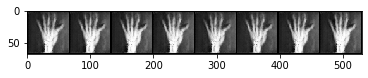

Epoch: 30	Batch: 147/148
Loss G: 5.2246599197387695
Loss D: 0.006498866248875856
Epoch: 31/100
Example images:


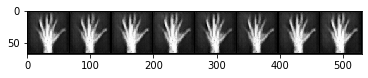

Epoch: 31	Batch: 147/148
Loss G: 8.767054557800293
Loss D: 0.004643735010176897
Epoch: 32/100
Example images:


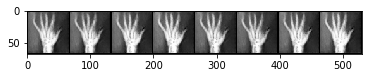

Epoch: 32	Batch: 147/148
Loss G: 5.358883380889893
Loss D: 0.040984220802783966
Epoch: 33/100
Example images:


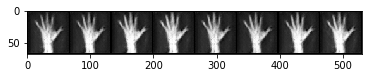

Epoch: 33	Batch: 147/148
Loss G: 6.668468475341797
Loss D: 0.001307883532717824
Epoch: 34/100
Example images:


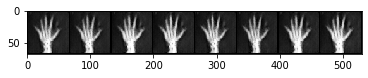

Epoch: 34	Batch: 147/148
Loss G: 3.5218377113342285
Loss D: 0.10436803847551346
Epoch: 35/100
Example images:


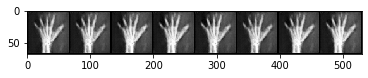

Epoch: 35	Batch: 147/148
Loss G: 4.358767509460449
Loss D: 0.041009820997714996
Epoch: 36/100
Example images:


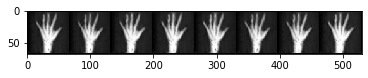

Epoch: 36	Batch: 147/148
Loss G: 9.895968437194824
Loss D: 0.09284241497516632
Epoch: 37/100
Example images:


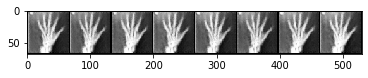

Epoch: 37	Batch: 147/148
Loss G: 3.83052921295166
Loss D: 0.03348473832011223
Epoch: 38/100
Example images:


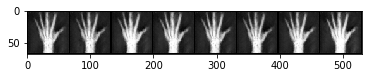

Epoch: 38	Batch: 147/148
Loss G: 8.292707443237305
Loss D: 0.0008488109451718628
Epoch: 39/100
Example images:


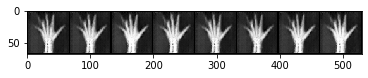

Epoch: 39	Batch: 147/148
Loss G: 6.666899681091309
Loss D: 0.0017660277662798762
Epoch: 40/100
Example images:


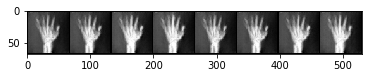

Epoch: 40	Batch: 147/148
Loss G: 6.178282737731934
Loss D: 0.012602153234183788
Epoch: 41/100
Example images:


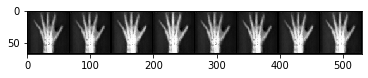

Epoch: 41	Batch: 147/148
Loss G: 5.0916218757629395
Loss D: 0.024729236960411072
Epoch: 42/100
Example images:


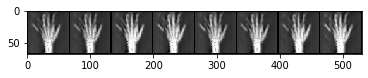

Epoch: 42	Batch: 147/148
Loss G: 4.160942077636719
Loss D: 0.04264683648943901
Epoch: 43/100
Example images:


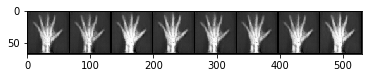

Epoch: 43	Batch: 147/148
Loss G: 12.335820198059082
Loss D: 0.0002816117776092142
Epoch: 44/100
Example images:


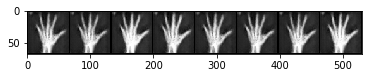

Epoch: 44	Batch: 147/148
Loss G: 4.812316417694092
Loss D: 0.07609850913286209
Epoch: 45/100
Example images:


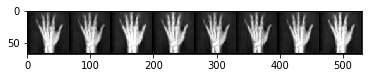

Epoch: 45	Batch: 147/148
Loss G: 4.681732177734375
Loss D: 0.02055312506854534
Epoch: 46/100
Example images:


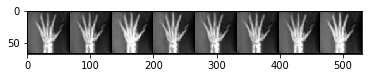

Epoch: 46	Batch: 147/148
Loss G: 5.116375923156738
Loss D: 0.010848875157535076
Epoch: 47/100
Example images:


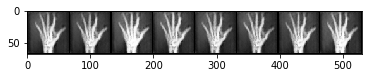

Epoch: 47	Batch: 147/148
Loss G: 4.055930137634277
Loss D: 0.02598802000284195
Epoch: 48/100
Example images:


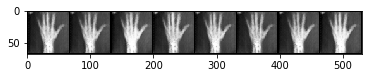

Epoch: 48	Batch: 147/148
Loss G: 5.074636936187744
Loss D: 0.01351644191890955
Epoch: 49/100
Example images:


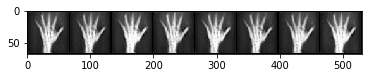

Epoch: 49	Batch: 147/148
Loss G: 8.266502380371094
Loss D: 0.00038158646202646196
Epoch: 50/100
Example images:


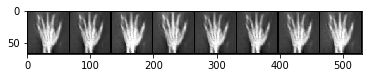

Epoch: 50	Batch: 147/148
Loss G: 4.496048450469971
Loss D: 0.0445382222533226
Epoch: 51/100
Example images:


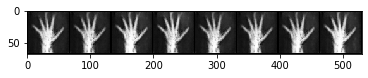

Epoch: 51	Batch: 147/148
Loss G: 4.202208995819092
Loss D: 0.05882365256547928
Epoch: 52/100
Example images:


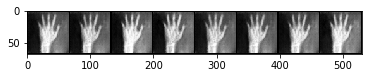

Epoch: 52	Batch: 147/148
Loss G: 6.086203098297119
Loss D: 0.013322207145392895
Epoch: 53/100
Example images:


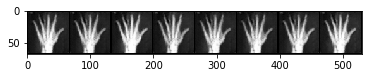

Epoch: 53	Batch: 147/148
Loss G: 7.483048915863037
Loss D: 0.3632566034793854
Epoch: 54/100
Example images:


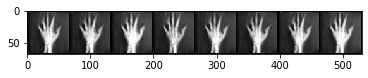

Epoch: 54	Batch: 147/148
Loss G: 15.140621185302734
Loss D: 8.80398802109994e-05
Epoch: 55/100
Example images:


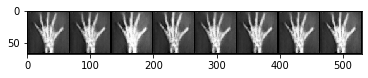

Epoch: 55	Batch: 147/148
Loss G: 11.546030044555664
Loss D: 0.0061002206057310104
Epoch: 56/100
Example images:


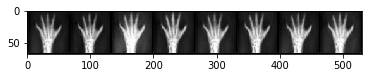

Epoch: 56	Batch: 147/148
Loss G: 5.340367317199707
Loss D: 0.015699900686740875
Epoch: 57/100
Example images:


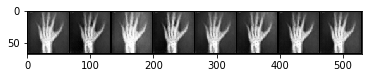

Epoch: 57	Batch: 147/148
Loss G: 5.676351070404053
Loss D: 0.007746296934783459
Epoch: 58/100
Example images:


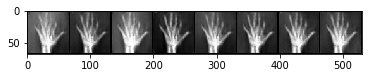

Epoch: 58	Batch: 147/148
Loss G: 9.803155899047852
Loss D: 0.00012541426985990256
Epoch: 59/100
Example images:


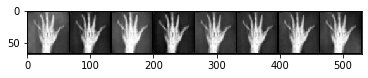

Epoch: 59	Batch: 147/148
Loss G: 13.984840393066406
Loss D: 4.5419717935146764e-05
Epoch: 60/100
Example images:


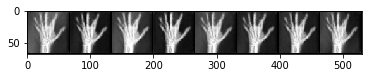

Epoch: 60	Batch: 147/148
Loss G: 6.3127593994140625
Loss D: 0.004472509026527405
Epoch: 61/100
Example images:


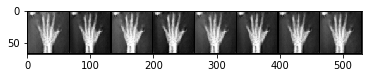

Epoch: 61	Batch: 147/148
Loss G: 9.331988334655762
Loss D: 0.008115818724036217
Epoch: 62/100
Example images:


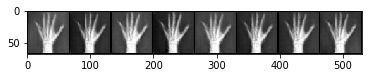

Epoch: 62	Batch: 147/148
Loss G: 5.430572986602783
Loss D: 0.007133129984140396
Epoch: 63/100
Example images:


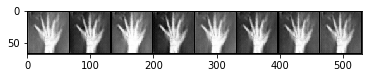

Epoch: 63	Batch: 147/148
Loss G: 18.164459228515625
Loss D: 0.0027017102111130953
Epoch: 64/100
Example images:


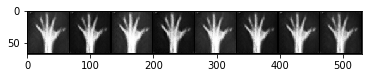

Epoch: 64	Batch: 147/148
Loss G: 5.519099712371826
Loss D: 0.014475816860795021
Epoch: 65/100
Example images:


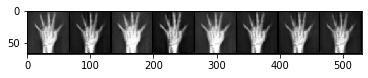

Epoch: 65	Batch: 147/148
Loss G: 9.243444442749023
Loss D: 0.00012344862625468522
Epoch: 66/100
Example images:


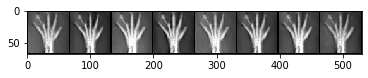

Epoch: 66	Batch: 147/148
Loss G: 10.523685455322266
Loss D: 0.6406054496765137
Epoch: 67/100
Example images:


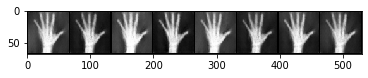

Epoch: 67	Batch: 147/148
Loss G: 5.813753128051758
Loss D: 0.006096970289945602
Epoch: 68/100
Example images:


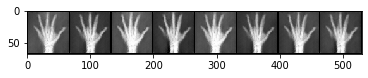

Epoch: 68	Batch: 147/148
Loss G: 8.59488296508789
Loss D: 0.0005354522145353258
Epoch: 69/100
Example images:


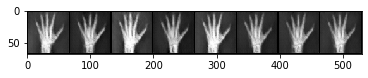

Epoch: 69	Batch: 147/148
Loss G: 4.662899971008301
Loss D: 0.050585031509399414
Epoch: 70/100
Example images:


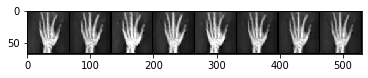

Epoch: 70	Batch: 147/148
Loss G: 4.636142253875732
Loss D: 0.04992798715829849
Epoch: 71/100
Example images:


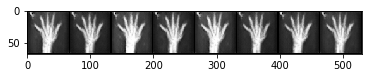

Epoch: 71	Batch: 147/148
Loss G: 5.153836250305176
Loss D: 0.01213491428643465
Epoch: 72/100
Example images:


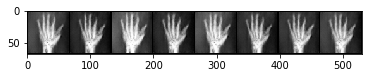

Epoch: 72	Batch: 147/148
Loss G: 8.453781127929688
Loss D: 0.0004907252150587738
Epoch: 73/100
Example images:


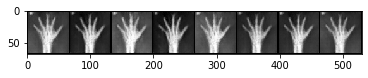

Epoch: 73	Batch: 147/148
Loss G: 4.896072864532471
Loss D: 0.04340249300003052
Epoch: 74/100
Example images:


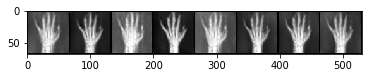

Epoch: 74	Batch: 147/148
Loss G: 4.552978515625
Loss D: 0.019548702985048294
Epoch: 75/100
Example images:


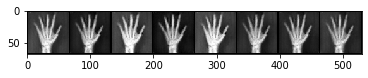

Epoch: 75	Batch: 147/148
Loss G: 5.548099517822266
Loss D: 0.00890133623033762
Epoch: 76/100
Example images:


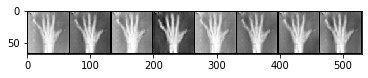

Epoch: 76	Batch: 147/148
Loss G: 3.3365137577056885
Loss D: 0.14645874500274658
Epoch: 77/100
Example images:


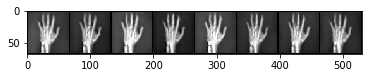

Epoch: 77	Batch: 147/148
Loss G: 5.4231696128845215
Loss D: 0.12076638638973236
Epoch: 78/100
Example images:


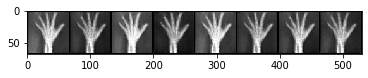

Epoch: 78	Batch: 147/148
Loss G: 5.791323661804199
Loss D: 0.0053450968116521835
Epoch: 79/100
Example images:


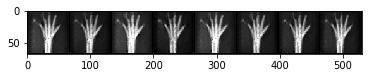

Epoch: 79	Batch: 147/148
Loss G: 5.012757301330566
Loss D: 0.004980957135558128
Epoch: 80/100
Example images:


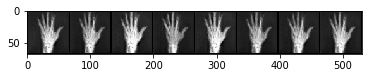

Epoch: 80	Batch: 147/148
Loss G: 19.193355560302734
Loss D: 8.463895028398838e-06
Epoch: 81/100
Example images:


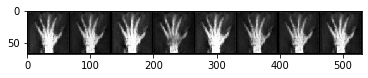

Epoch: 81	Batch: 147/148
Loss G: 5.841719150543213
Loss D: 0.04744134843349457
Epoch: 82/100
Example images:


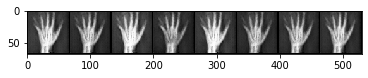

Epoch: 82	Batch: 147/148
Loss G: 4.990715503692627
Loss D: 0.023341674357652664
Epoch: 83/100
Example images:


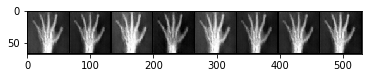

Epoch: 83	Batch: 147/148
Loss G: 4.878012180328369
Loss D: 0.024407312273979187
Epoch: 84/100
Example images:


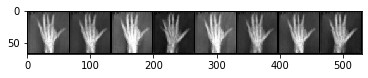

Epoch: 84	Batch: 147/148
Loss G: 5.051713466644287
Loss D: 0.009784523397684097
Epoch: 85/100
Example images:


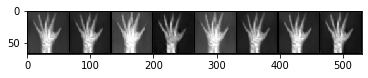

Epoch: 85	Batch: 147/148
Loss G: 8.329970359802246
Loss D: 0.0004959186189807951
Epoch: 86/100
Example images:


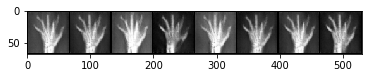

Epoch: 86	Batch: 147/148
Loss G: 6.092495918273926
Loss D: 0.0031727536115795374
Epoch: 87/100
Example images:


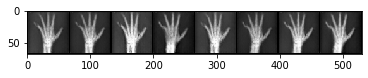

Epoch: 87	Batch: 147/148
Loss G: 8.033435821533203
Loss D: 0.001752037089318037
Epoch: 88/100
Example images:


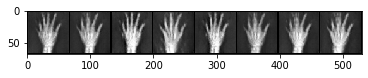

Epoch: 88	Batch: 147/148
Loss G: 11.967764854431152
Loss D: 2.8074162401026115e-05
Epoch: 89/100
Example images:


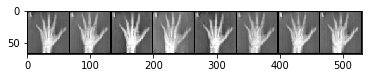

Epoch: 89	Batch: 147/148
Loss G: 4.102007865905762
Loss D: 0.06811952590942383
Epoch: 90/100
Example images:


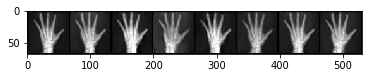

Epoch: 90	Batch: 147/148
Loss G: 6.241340637207031
Loss D: 0.003485187189653516
Epoch: 91/100
Example images:


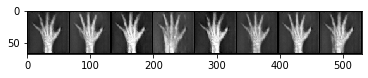

Epoch: 91	Batch: 147/148
Loss G: 5.271315574645996
Loss D: 0.009561324492096901
Epoch: 92/100
Example images:


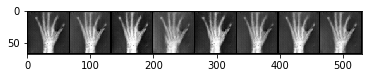

Epoch: 92	Batch: 147/148
Loss G: 6.160759449005127
Loss D: 0.0034384755417704582
Epoch: 93/100
Example images:


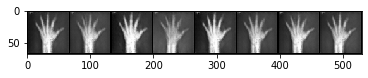

Epoch: 93	Batch: 147/148
Loss G: 5.573575019836426
Loss D: 0.013423825614154339
Epoch: 94/100
Example images:


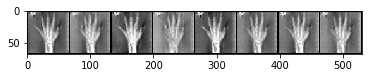

Epoch: 94	Batch: 147/148
Loss G: 4.336242198944092
Loss D: 0.07390809804201126
Epoch: 95/100
Example images:


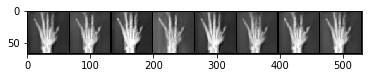

Epoch: 95	Batch: 147/148
Loss G: 5.145665645599365
Loss D: 0.022570624947547913
Epoch: 96/100
Example images:


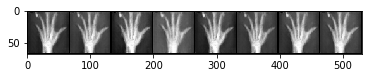

Epoch: 96	Batch: 147/148
Loss G: 5.942000865936279
Loss D: 0.05323650315403938
Epoch: 97/100
Example images:


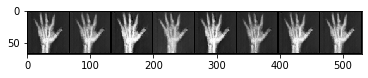

Epoch: 97	Batch: 147/148
Loss G: 8.495813369750977
Loss D: 0.010142131708562374
Epoch: 98/100
Example images:


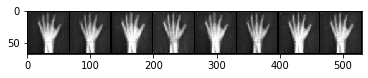

Epoch: 98	Batch: 147/148
Loss G: 11.29687786102295
Loss D: 1.62125397764612e-05
Epoch: 99/100
Example images:


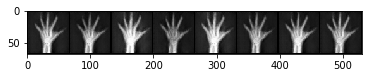

Epoch: 99	Batch: 147/148
Loss G: 9.32685375213623
Loss D: 8.148231427185237e-05


In [14]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch}/{n_epochs}")
    print("Example images:")
    generated_images = G(test_noise).detach().cpu()
    show_images(generated_images)
    
    for i, (batch, _) in enumerate(data_loader):
        print(f"\rEpoch: {epoch}\tBatch: {i}/{len(data_loader)}", end='')
        ####
        D.zero_grad()

        #
        real = Variable(batch).to(gpu)
        real_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        real_predictions = D(real)
        d_error_real = compute_loss(real_predictions, real_labels)
        
        # 
        noise = Variable(torch.randn(real.size(0), 100, 1, 1)).to(gpu)
        fake = G(noise)
        fake_predictions = D(fake.detach())
        fake_labels = Variable(torch.zeros(real.size(0), 1, 1, 1)).to(gpu)
        d_error_fake = compute_loss(fake_predictions, fake_labels)
        
        # 
        d_error_total = d_error_real + d_error_fake
        d_error_total.backward()
        optimizer_d.step()
        
        ####
        G.zero_grad()
        
        # 
        goal_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        results = D(fake)
        g_error = compute_loss(results, goal_labels)
        
        # 
        g_error.backward()
        optimizer_g.step()
    
    print("")
    print(f"Loss G: {g_error}")
    print(f"Loss D: {d_error_total}")

In [ ]:
# -- 짜징 데이터 부족인가봄

In [ ]:
# torch.save(G.state_dict(), "trained_generator")
# torch.save(D.state_dict(), "trained_discriminator")

# Try trained GAN

In [1]:
import torchvision
import torch
from torch import nn

In [2]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100, 
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            
            # Output Layer
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.main(x)
        return x

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

In [6]:
G = Generator()
G.load_state_dict(torch.load('/content/drive/MyDrive/cakd_colab/python_practice/trained_generator'))

<All keys matched successfully>

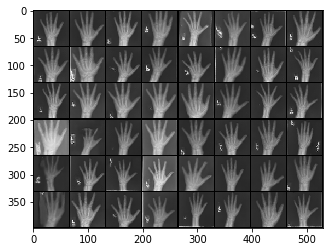

In [7]:
noise = torch.randn(48, 100, 1, 1)

images = G(noise).detach()
images.shape

show_images(images)